In [1]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# --- Configuration ---
config = {
    "data_dir": "data",
    "model_name": "distilbert-base-multilingual-cased",
    "batch_size": 8,
    "max_length": 512,
    "learning_rate": 2e-5,
    "num_folds": 10,
    "num_epochs": 10,
    "early_stopping_patience": 3,
    "output_dir": "xlm-roberta-finetuned"
}

# --- Device Setup ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


# --- Load and Preprocess Dataset ---

In [3]:
def load_dataset(data_dir):
    texts, labels = [], []
    author_to_label = {author: idx for idx, author in enumerate(sorted(os.listdir(data_dir)))}
    for author, label in author_to_label.items():
        author_dir = os.path.join(data_dir, author)
        if os.path.isdir(author_dir):
            for file_name in os.listdir(author_dir):
                file_path = os.path.join(author_dir, file_name)
                try:
                    with open(file_path, 'r', encoding='ISO-8859-1') as file:
                        texts.append(file.read())
                        labels.append(label)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    return texts, labels, author_to_label

# Load dataset
texts, labels, author_to_label = load_dataset(config["data_dir"])
print(f"Loaded {len(texts)} samples from {config['data_dir']}.")


Loaded 1500 samples from data.


# --- Tokenization ---

In [4]:
tokenizer = AutoTokenizer.from_pretrained(config["model_name"])

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, max_length=self.max_length, truncation=True, padding="max_length", return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# --- Training Loop ---

In [5]:
def train_epoch(model, dataloader, optimizer, scheduler, loss_fn, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training", unit="batch")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    scheduler.step(total_loss)
    return total_loss / len(dataloader)

def evaluate_epoch(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds, all_labels = [], []
    progress_bar = tqdm(dataloader, desc="Evaluating", unit="batch")
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            preds = outputs.logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy, all_preds, all_labels

In [6]:
# --- Generate Combined Visualization for Each Fold ---
def generate_combined_plots(train_losses, val_losses, val_accuracies, all_labels, all_preds, num_classes, fold):
    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

    # Create a figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))

    # Plot Loss and Accuracy
    epochs = range(1, len(train_losses) + 1)
    axes[0].plot(epochs, train_losses, label="Train Loss", marker='o')
    axes[0].plot(epochs, val_losses, label="Validation Loss", marker='o')
    axes[0].plot(epochs, val_accuracies, label="Validation Accuracy", marker='o', color='green')
    axes[0].set_title(f"Loss and Accuracy - Fold {fold}")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Value")
    axes[0].legend()
    axes[0].grid()

    # Plot Performance Metrics (Side-by-Side Bars)
    class_labels = [f"Class {i+1}" for i in range(num_classes)]
    x = np.arange(len(class_labels))  # Class indices
    bar_width = 0.25
    axes[1].bar(x - bar_width, precision, width=bar_width, label="Precision", color='blue')
    axes[1].bar(x, recall, width=bar_width, label="Recall", color='orange')
    axes[1].bar(x + bar_width, f1, width=bar_width, label="F1-Score", color='green')
    axes[1].set_title(f"Performance Metrics - Fold {fold}")
    axes[1].set_xlabel("Classes")
    axes[1].set_ylabel("Scores")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(class_labels, rotation=90)
    axes[1].legend()
    axes[1].grid()

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=axes[2], cmap="viridis", xticks_rotation="vertical")
    axes[2].set_title(f"Confusion Matrix - Fold {fold}")

    # Adjust layout and show
    plt.tight_layout()
    plt.show()

def save_fold_metrics(all_labels, all_preds, num_classes, fold):
    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    # Averages
    precision_avg = precision.mean()
    recall_avg = recall.mean()
    f1_avg = f1.mean()

    # Save metrics to CSV
    class_labels = [f"Class {i+1}" for i in range(num_classes)] + ["Average"]
    metrics_data = {
        "Class": class_labels,
        "Precision": list(precision) + [precision_avg],
        "Recall": list(recall) + [recall_avg],
        "F1-Score": list(f1) + [f1_avg],
    }
    df_metrics = pd.DataFrame(metrics_data)

    # Save the file for the current fold
    csv_filename = f"performance_metrics_fold_{fold}.csv"
    df_metrics.to_csv(csv_filename, index=False)
    print(f"Metrics for Fold {fold} saved to '{csv_filename}'.")

    return precision_avg, recall_avg, f1_avg


# --- Cross-Validation with Training Progress ---

In [7]:
def cross_validate_with_combined_plots(model_name, tokenizer, texts, labels, config):
    skf = StratifiedKFold(n_splits=config["num_folds"], shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels), start=1):
        print(f"Fold {fold}/{config['num_folds']}")
        train_texts, val_texts = [texts[i] for i in train_idx], [texts[i] for i in val_idx]
        train_labels, val_labels = [labels[i] for i in train_idx], [labels[i] for i in val_idx]

        train_dataset = TextDataset(train_texts, train_labels, tokenizer, config["max_length"])
        val_dataset = TextDataset(val_texts, val_labels, tokenizer, config["max_length"])
        train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config["batch_size"])

        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(labels))).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"])
        scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2)
        loss_fn = nn.CrossEntropyLoss()

        best_val_loss = float("inf")
        patience_counter = 0
        train_losses, val_losses, val_accuracies = [], [], []

        for epoch in range(config["num_epochs"]):
            print(f"Epoch {epoch + 1}/{config['num_epochs']}")
            train_loss = train_epoch(model, train_loader, optimizer, scheduler, loss_fn, device)
            val_loss, val_accuracy, all_preds, all_labels = evaluate_epoch(model, val_loader, loss_fn, device)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), f"best_model_fold_{fold}.pt")
            else:
                patience_counter += 1
                if patience_counter >= config["early_stopping_patience"]:
                    print("Early stopping triggered.")
                    break

        # Evaluate the best model
        model.load_state_dict(torch.load(f"best_model_fold_{fold}.pt"))
        val_loss, val_accuracy, all_preds, all_labels = evaluate_epoch(model, val_loader, loss_fn, device)

        # Save class-level metrics for the current fold
        num_classes = len(set(labels))
        precision_avg, recall_avg, f1_avg = save_fold_metrics(all_labels, all_preds, num_classes, fold)

        # Generate combined plots for this fold
        generate_combined_plots(train_losses, val_losses, val_accuracies, all_labels, all_preds, num_classes, fold)

        # Append fold-level results
        fold_results.append({
            "fold": fold,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "precision_avg": precision_avg,
            "recall_avg": recall_avg,
            "f1_avg": f1_avg,
        })

    return fold_results


# --- Execute Training ---

Fold 1/10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.77batch/s]


Validation Loss: 2.4777, Validation Accuracy: 0.2600
Epoch 2/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.85batch/s]


Validation Loss: 1.6413, Validation Accuracy: 0.5267
Epoch 3/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.72batch/s]


Validation Loss: 1.1021, Validation Accuracy: 0.6867
Epoch 4/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.83batch/s]


Validation Loss: 0.8215, Validation Accuracy: 0.7200
Epoch 5/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.78batch/s]


Validation Loss: 0.7765, Validation Accuracy: 0.7333
Epoch 6/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.70batch/s]


Validation Loss: 0.6971, Validation Accuracy: 0.7667
Epoch 7/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.77batch/s]


Validation Loss: 0.6277, Validation Accuracy: 0.7667
Epoch 8/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.61batch/s]


Validation Loss: 0.5916, Validation Accuracy: 0.7733
Epoch 9/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.89batch/s]


Validation Loss: 0.5663, Validation Accuracy: 0.8200
Epoch 10/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.85batch/s]


Validation Loss: 0.6228, Validation Accuracy: 0.7867


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.96batch/s]


Metrics for Fold 1 saved to 'performance_metrics_fold_1.csv'.


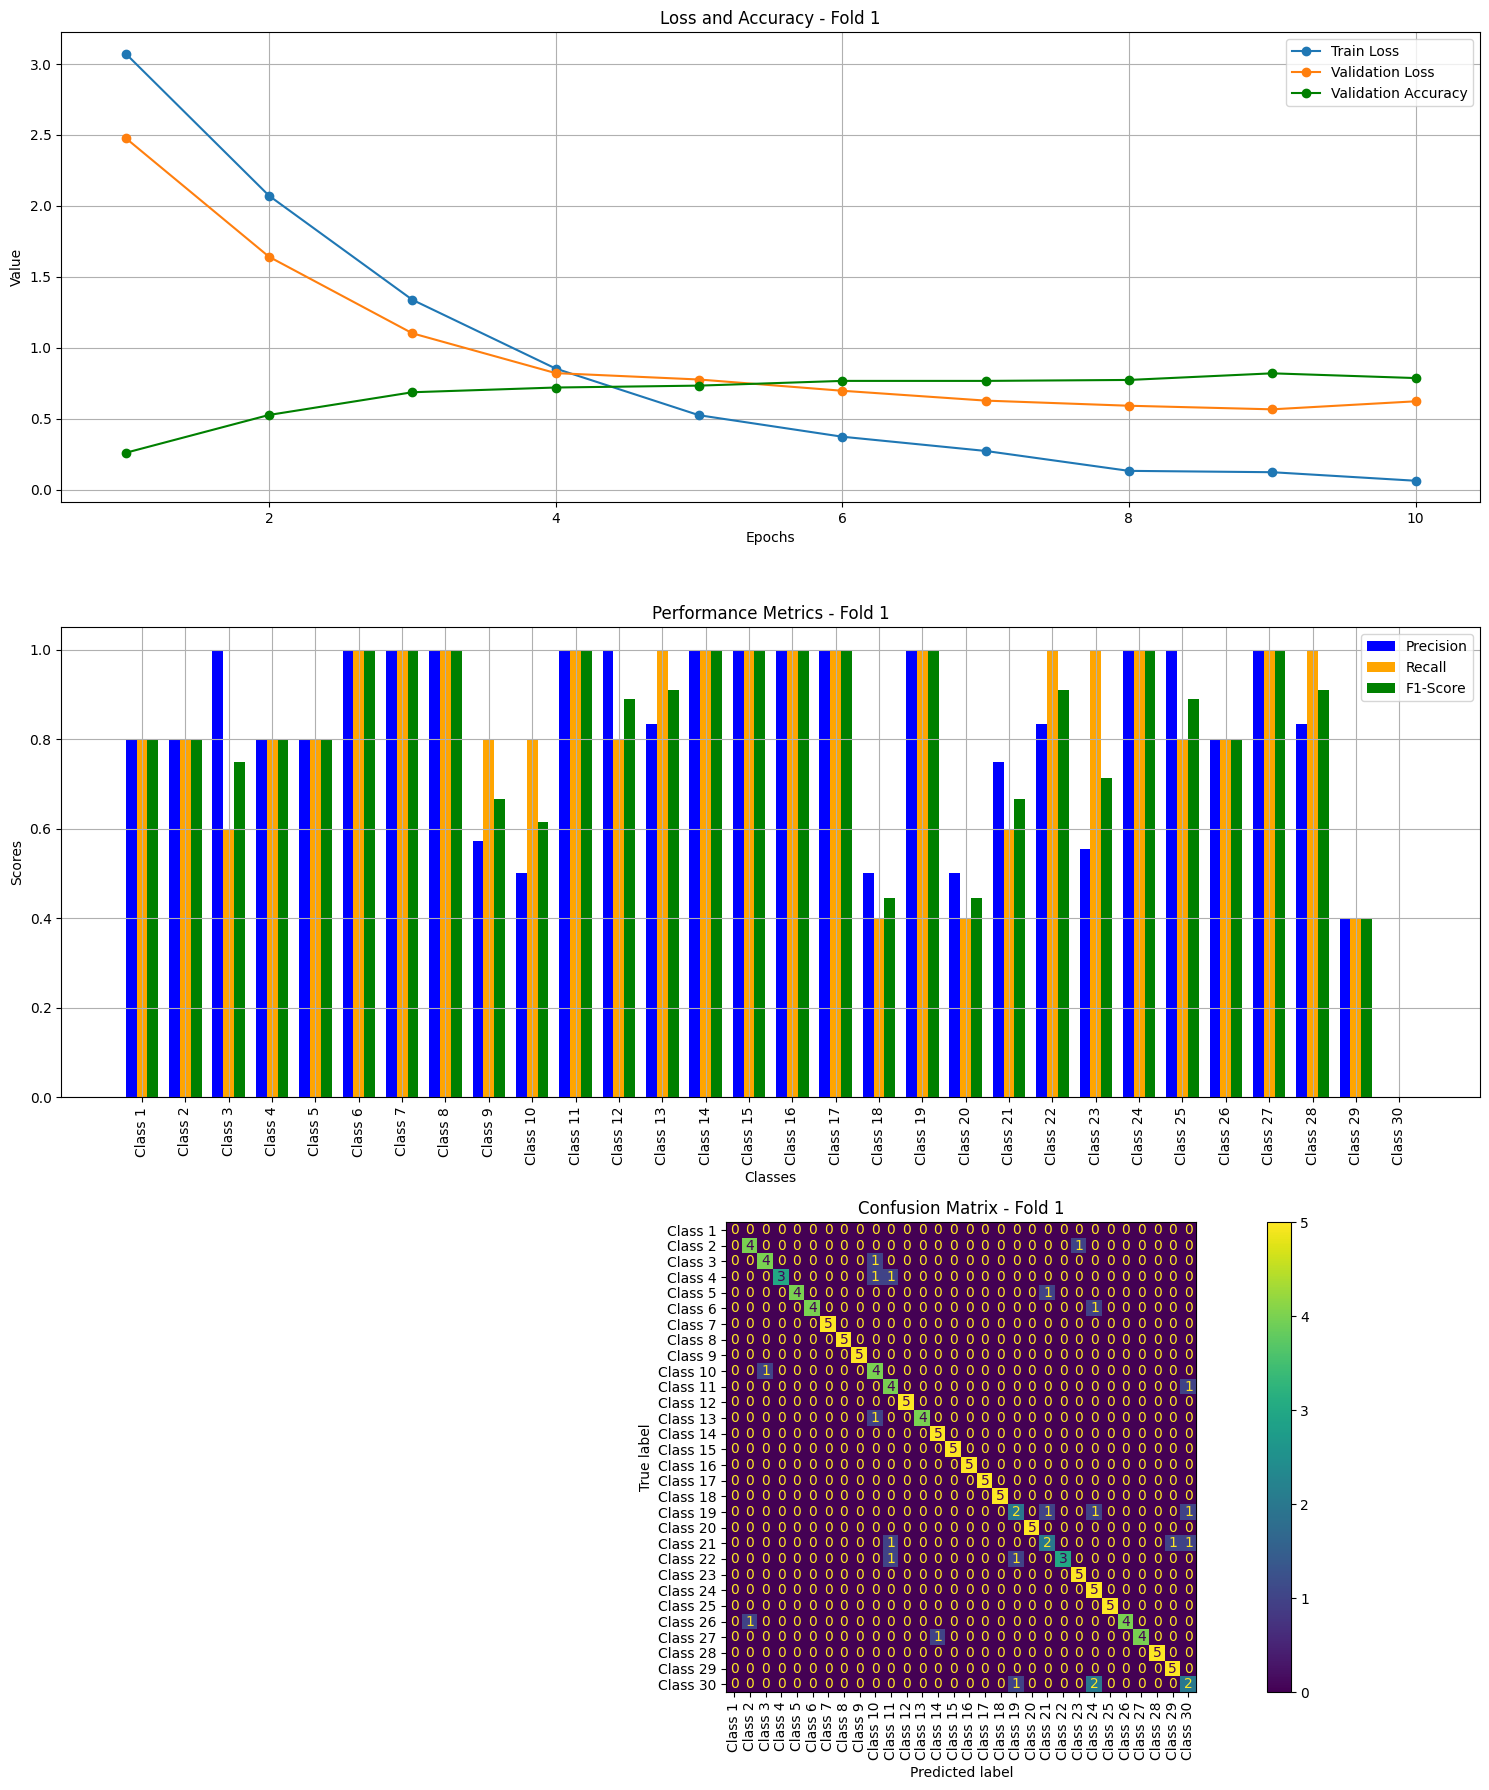

Fold 2/10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.91batch/s]


Validation Loss: 2.6025, Validation Accuracy: 0.2400
Epoch 2/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.78batch/s]


Validation Loss: 1.9022, Validation Accuracy: 0.4933
Epoch 3/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.47batch/s]


Validation Loss: 1.2025, Validation Accuracy: 0.6333
Epoch 4/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.68batch/s]


Validation Loss: 0.8872, Validation Accuracy: 0.7333
Epoch 5/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.78batch/s]


Validation Loss: 0.7413, Validation Accuracy: 0.7467
Epoch 6/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.75batch/s]


Validation Loss: 0.6225, Validation Accuracy: 0.8067
Epoch 7/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.74batch/s]


Validation Loss: 0.6652, Validation Accuracy: 0.7400
Epoch 8/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.84batch/s]


Validation Loss: 0.4663, Validation Accuracy: 0.8067
Epoch 9/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.70batch/s]


Validation Loss: 0.6837, Validation Accuracy: 0.7600
Epoch 10/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.78batch/s]


Validation Loss: 0.4278, Validation Accuracy: 0.8333


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.92batch/s]


Metrics for Fold 2 saved to 'performance_metrics_fold_2.csv'.


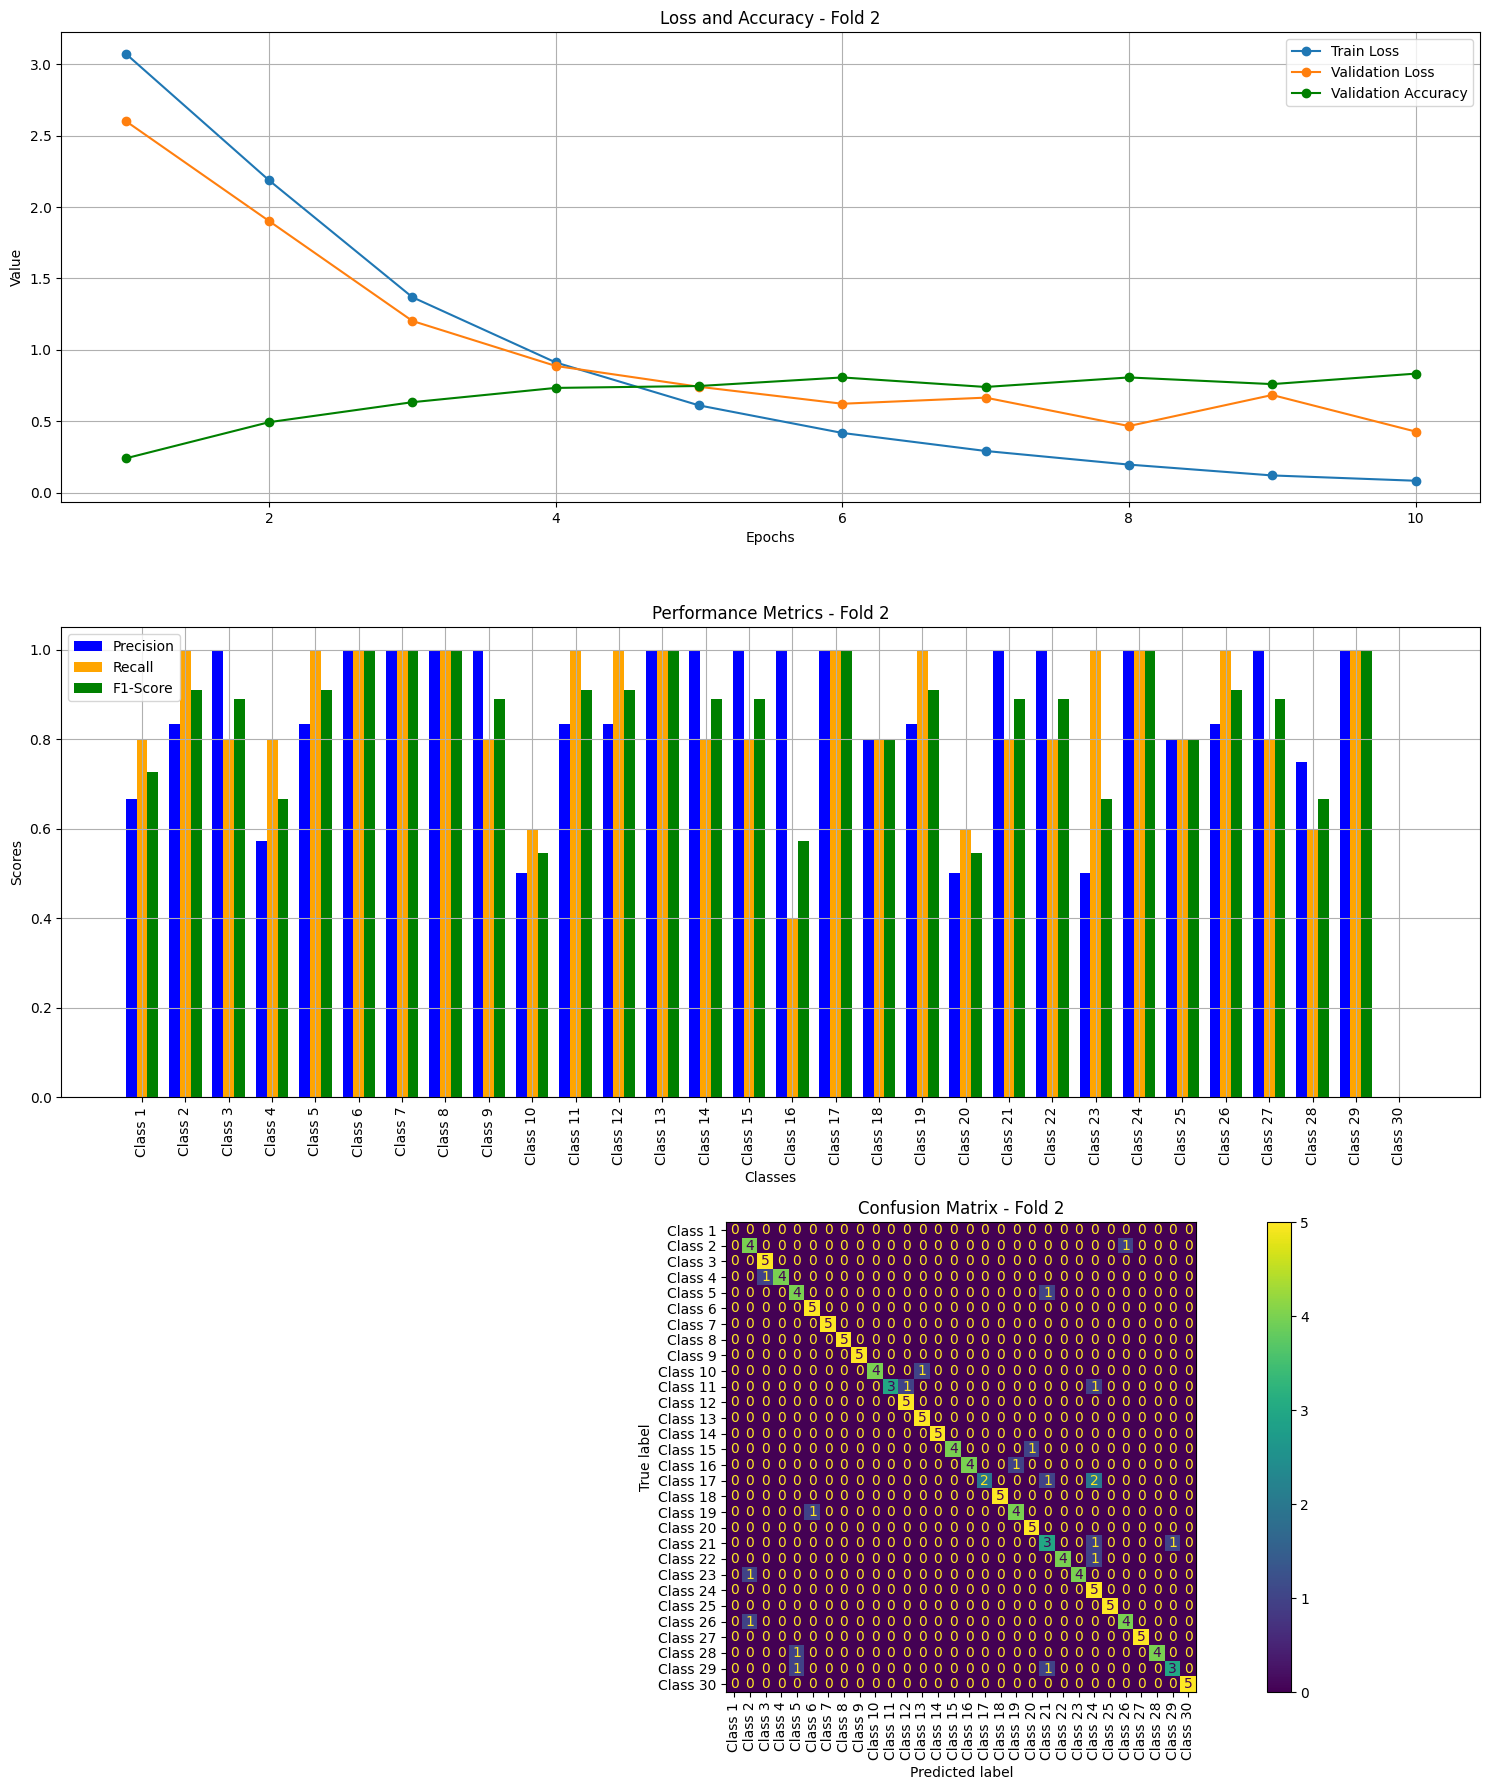

Fold 3/10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.74batch/s]


Validation Loss: 2.5967, Validation Accuracy: 0.2533
Epoch 2/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.80batch/s]


Validation Loss: 1.6603, Validation Accuracy: 0.5600
Epoch 3/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.79batch/s]


Validation Loss: 1.0227, Validation Accuracy: 0.7067
Epoch 4/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.85batch/s]


Validation Loss: 0.7638, Validation Accuracy: 0.7800
Epoch 5/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.86batch/s]


Validation Loss: 0.6395, Validation Accuracy: 0.7800
Epoch 6/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.92batch/s]


Validation Loss: 0.8040, Validation Accuracy: 0.7200
Epoch 7/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.85batch/s]


Validation Loss: 0.5834, Validation Accuracy: 0.7667
Epoch 8/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.90batch/s]


Validation Loss: 0.5481, Validation Accuracy: 0.8067
Epoch 9/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.91batch/s]


Validation Loss: 0.6370, Validation Accuracy: 0.7867
Epoch 10/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.90batch/s]


Validation Loss: 0.5904, Validation Accuracy: 0.8000


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.93batch/s]


Metrics for Fold 3 saved to 'performance_metrics_fold_3.csv'.


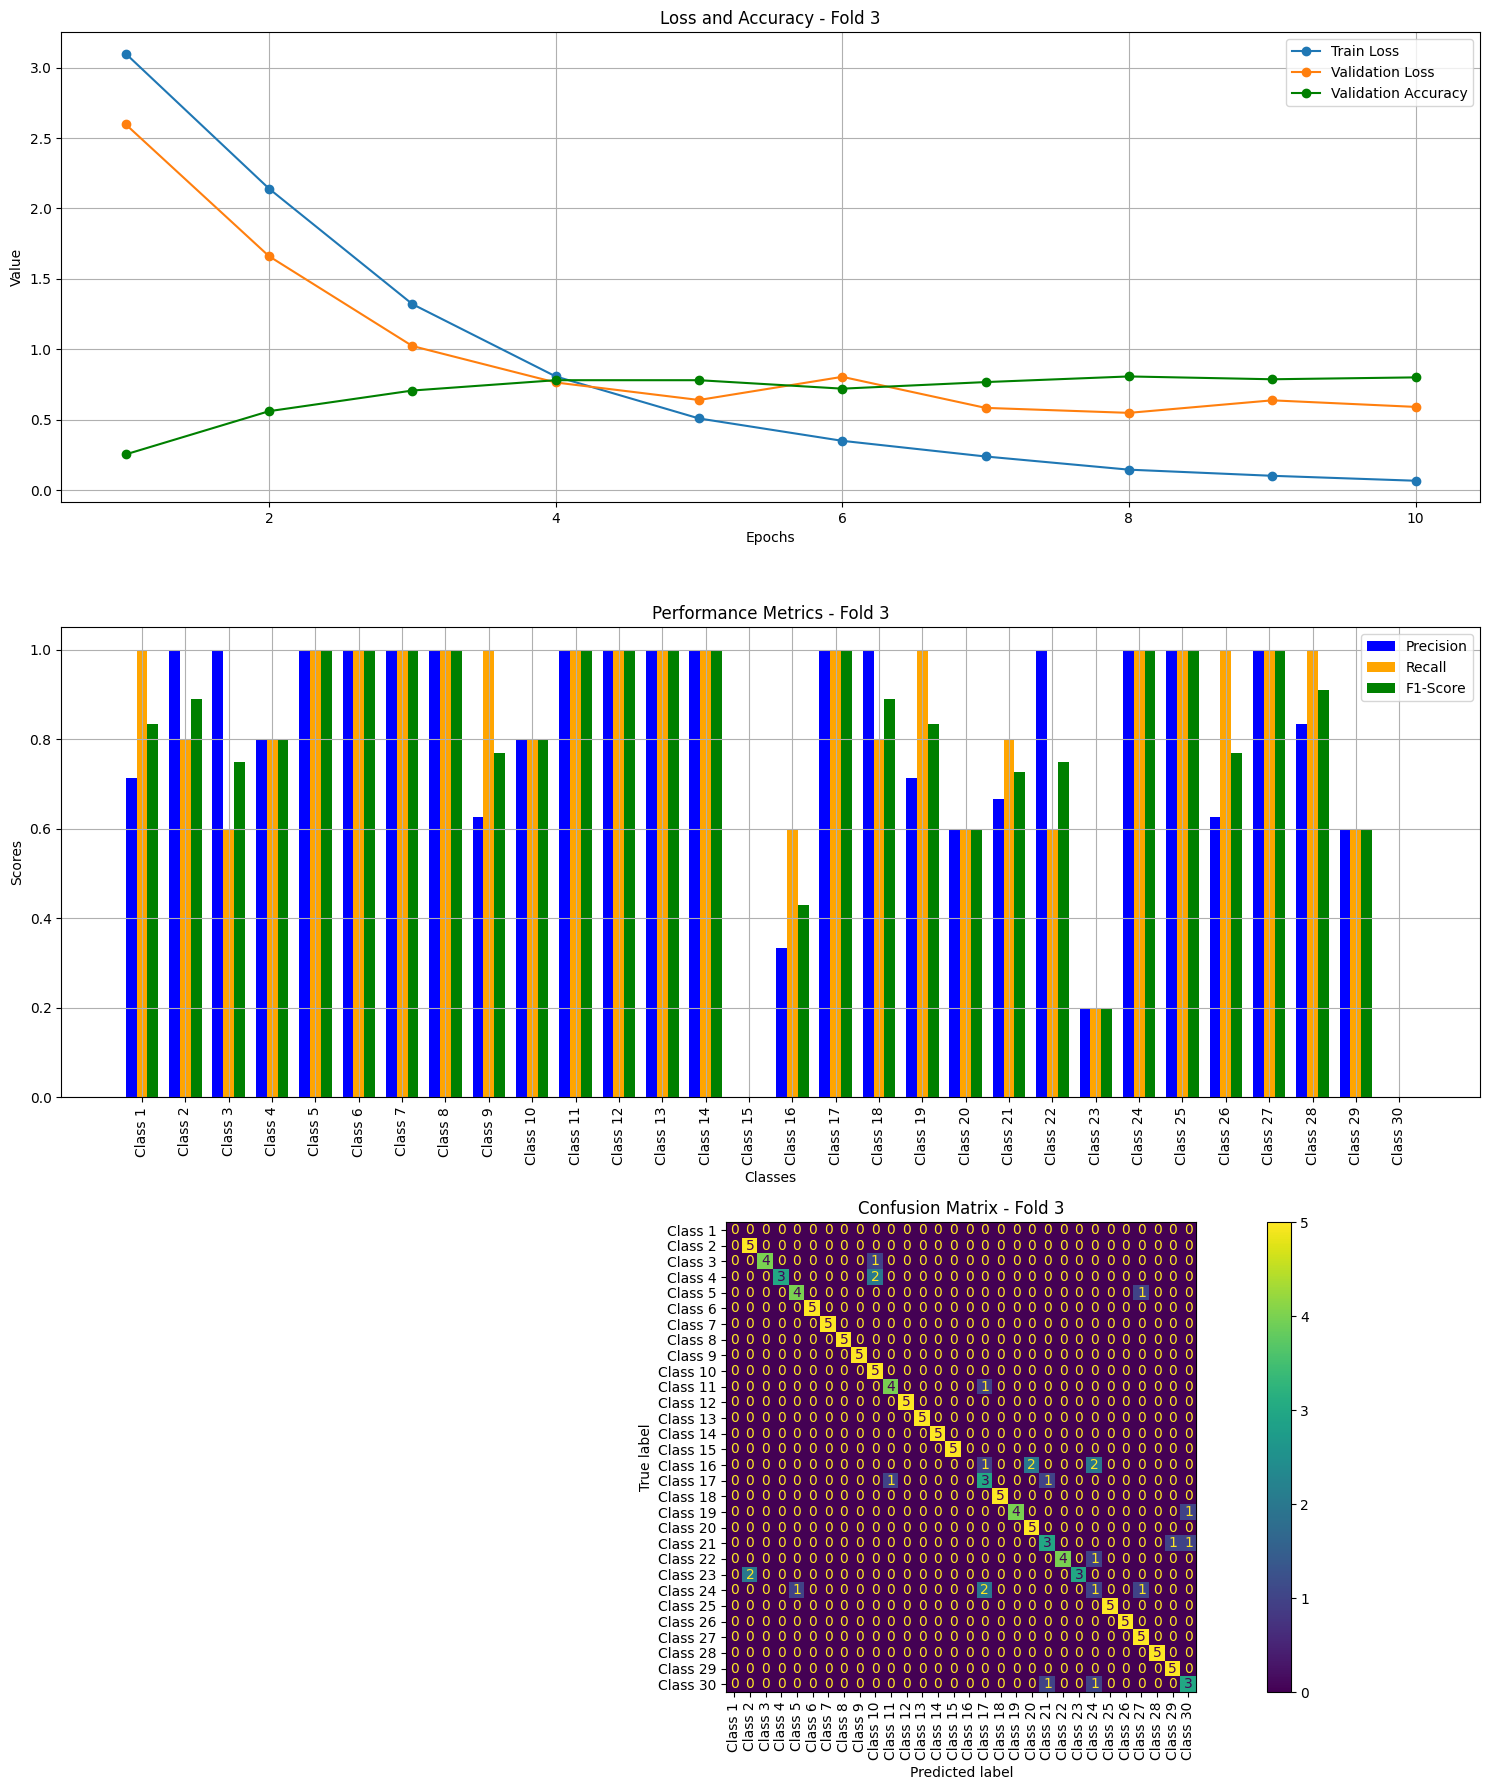

Fold 4/10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.83batch/s]


Validation Loss: 2.7075, Validation Accuracy: 0.2000
Epoch 2/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.72batch/s]


Validation Loss: 1.7297, Validation Accuracy: 0.5467
Epoch 3/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.86batch/s]


Validation Loss: 1.2016, Validation Accuracy: 0.6467
Epoch 4/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.86batch/s]


Validation Loss: 0.8724, Validation Accuracy: 0.7067
Epoch 5/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.80batch/s]


Validation Loss: 0.7364, Validation Accuracy: 0.7733
Epoch 6/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.72batch/s]


Validation Loss: 0.6148, Validation Accuracy: 0.8000
Epoch 7/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.80batch/s]


Validation Loss: 0.5185, Validation Accuracy: 0.7867
Epoch 8/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.80batch/s]


Validation Loss: 0.5417, Validation Accuracy: 0.8133
Epoch 9/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.69batch/s]


Validation Loss: 0.6545, Validation Accuracy: 0.7467
Epoch 10/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.77batch/s]


Validation Loss: 0.5406, Validation Accuracy: 0.8067
Early stopping triggered.


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.95batch/s]


Metrics for Fold 4 saved to 'performance_metrics_fold_4.csv'.


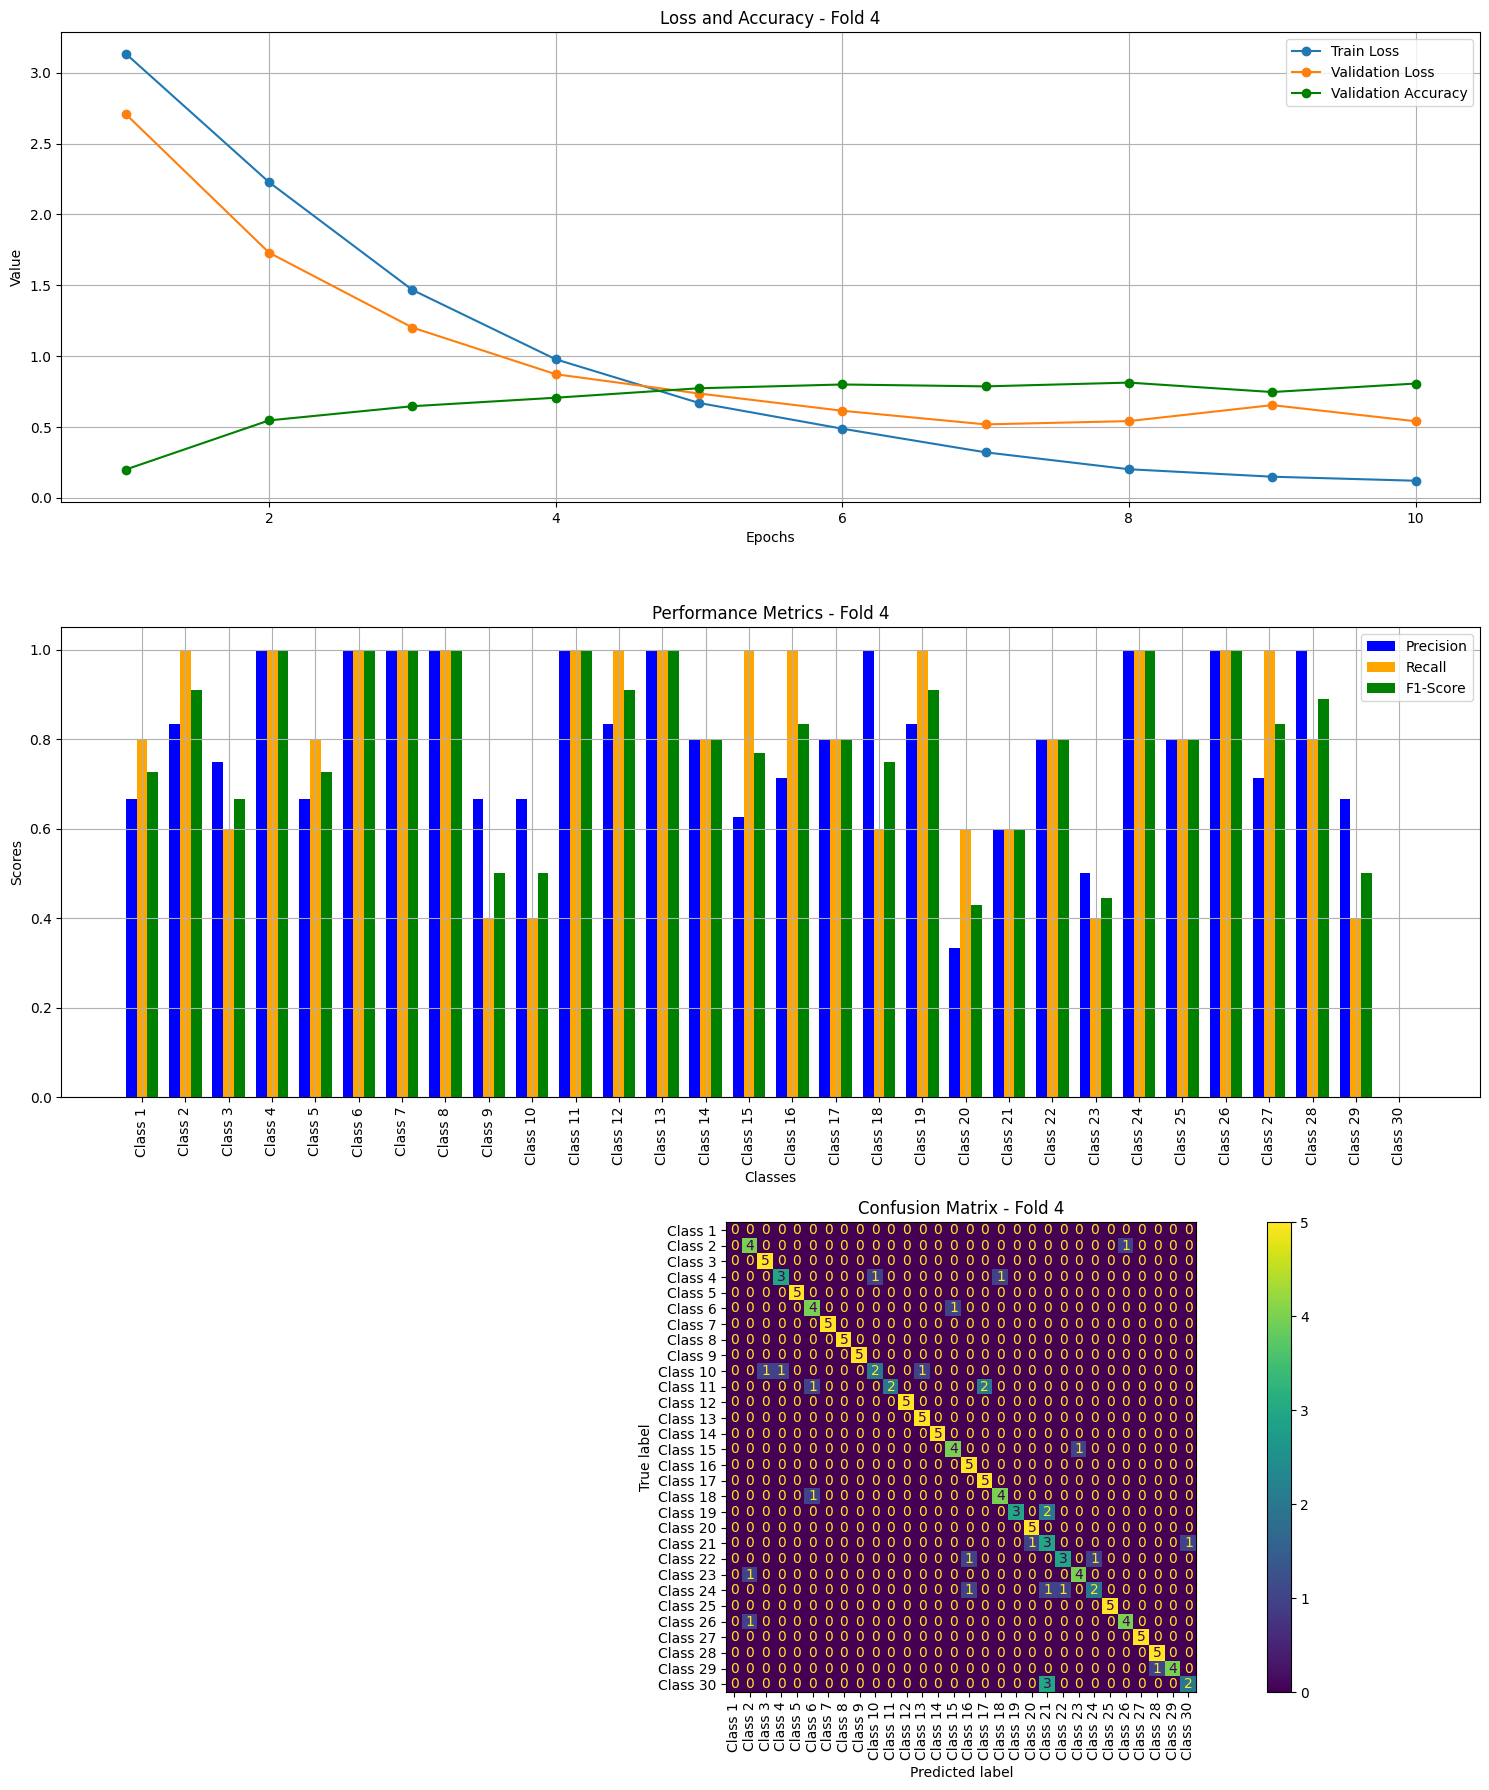

Fold 5/10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.64batch/s]


Validation Loss: 2.2606, Validation Accuracy: 0.4133
Epoch 2/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.80batch/s]


Validation Loss: 1.4753, Validation Accuracy: 0.5800
Epoch 3/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.72batch/s]


Validation Loss: 0.9316, Validation Accuracy: 0.7133
Epoch 4/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.76batch/s]


Validation Loss: 0.7480, Validation Accuracy: 0.7200
Epoch 5/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.81batch/s]


Validation Loss: 0.6813, Validation Accuracy: 0.7600
Epoch 6/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.87batch/s]


Validation Loss: 0.5611, Validation Accuracy: 0.7667
Epoch 7/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.98batch/s]


Validation Loss: 0.5763, Validation Accuracy: 0.7667
Epoch 8/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.81batch/s]


Validation Loss: 0.5566, Validation Accuracy: 0.7800
Epoch 9/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.87batch/s]


Validation Loss: 0.6499, Validation Accuracy: 0.7600
Epoch 10/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.84batch/s]


Validation Loss: 0.5691, Validation Accuracy: 0.8067


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.98batch/s]


Metrics for Fold 5 saved to 'performance_metrics_fold_5.csv'.


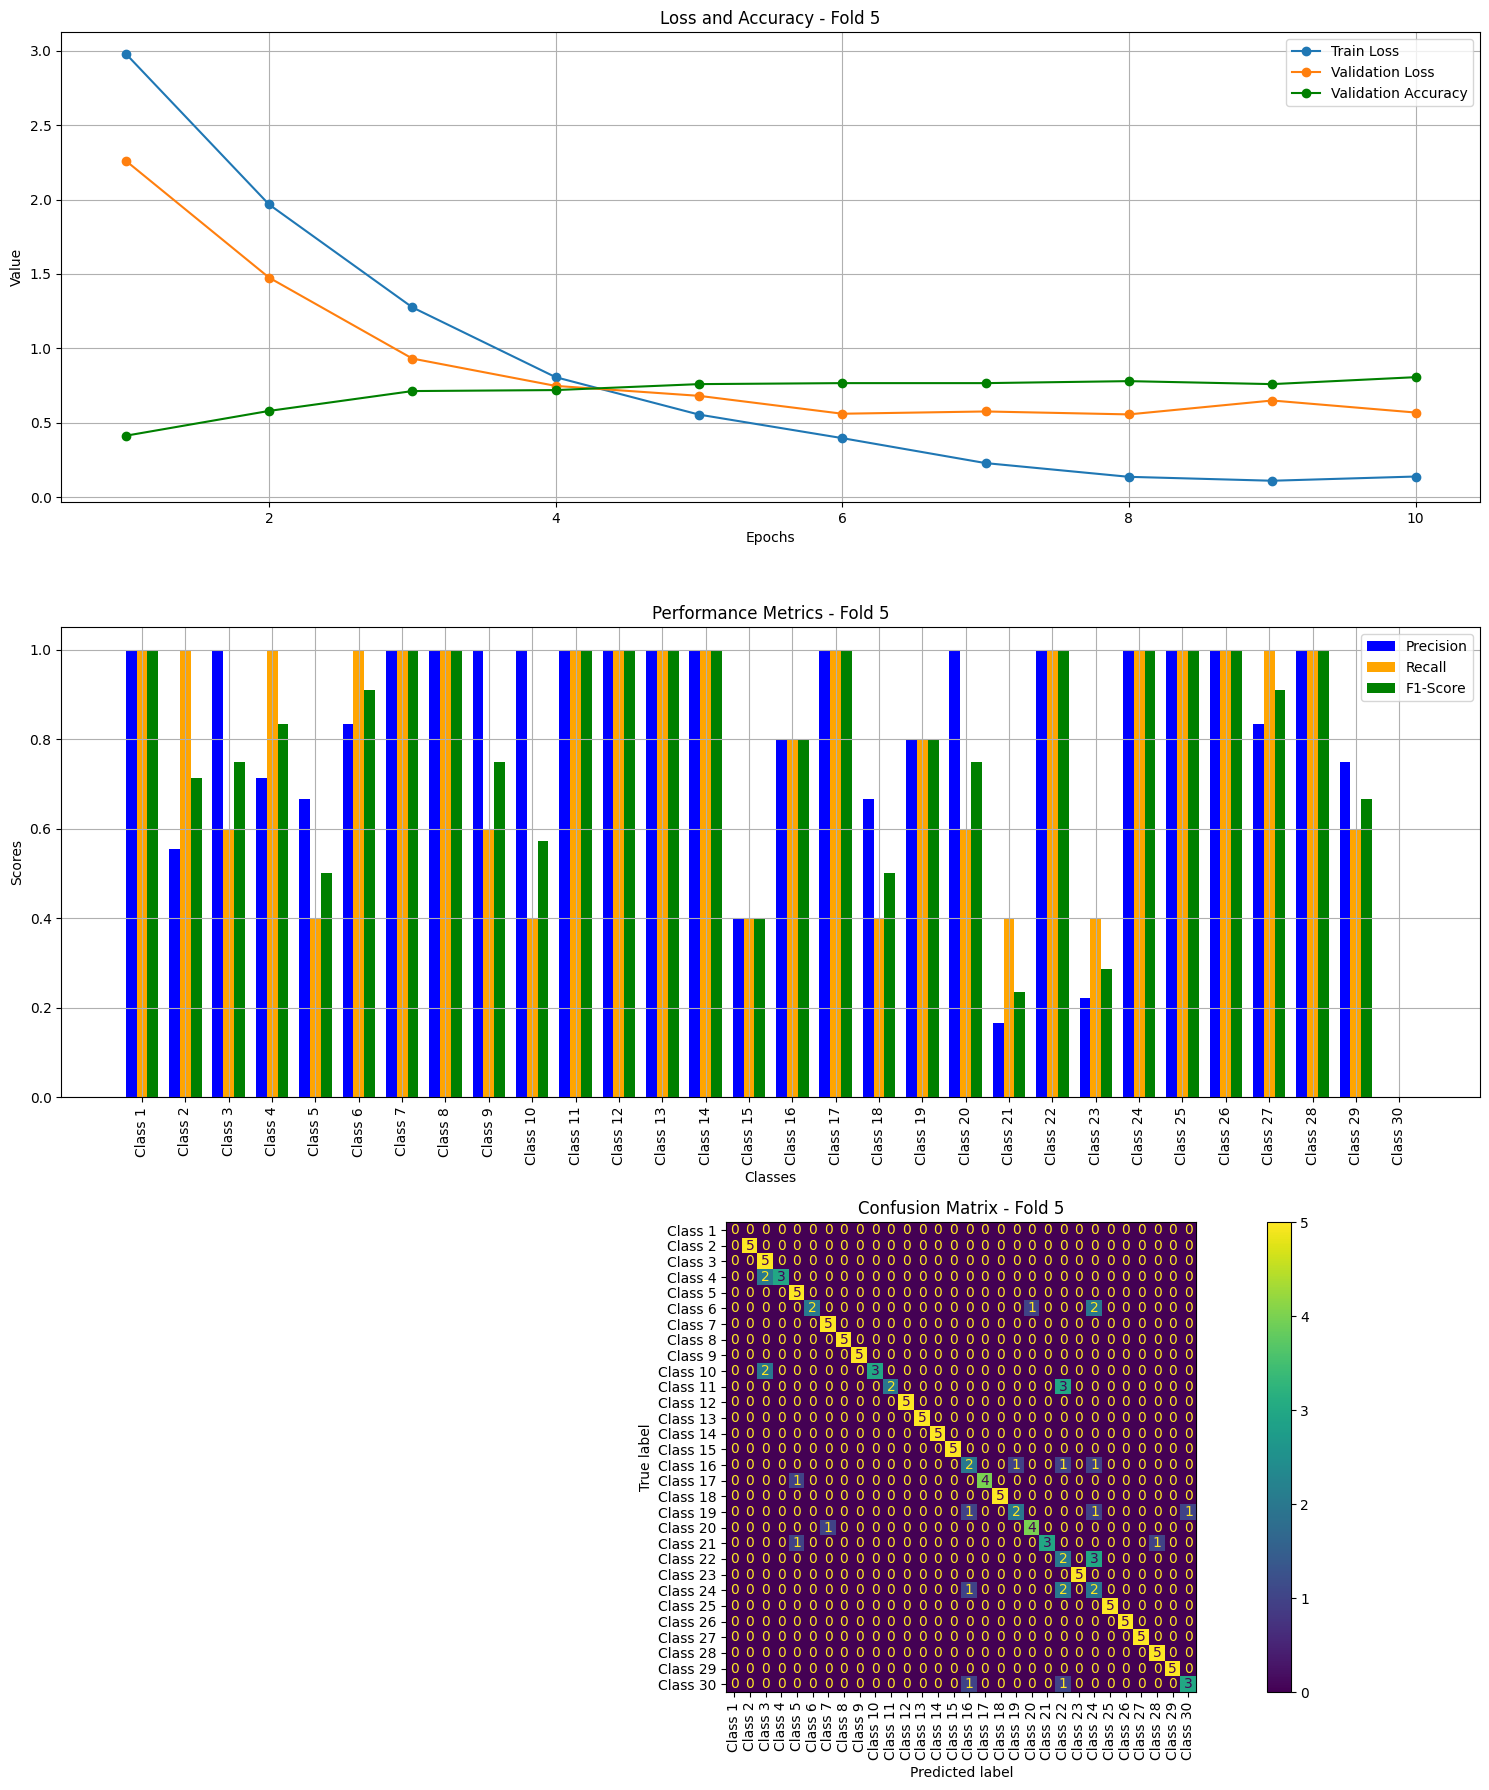

Fold 6/10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.87batch/s]


Validation Loss: 2.3709, Validation Accuracy: 0.3600
Epoch 2/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.86batch/s]


Validation Loss: 1.5393, Validation Accuracy: 0.5933
Epoch 3/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.81batch/s]


Validation Loss: 1.0813, Validation Accuracy: 0.6733
Epoch 4/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.88batch/s]


Validation Loss: 0.7570, Validation Accuracy: 0.7467
Epoch 5/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.85batch/s]


Validation Loss: 0.5982, Validation Accuracy: 0.8000
Epoch 6/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.87batch/s]


Validation Loss: 0.5186, Validation Accuracy: 0.8267
Epoch 7/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.83batch/s]


Validation Loss: 0.4990, Validation Accuracy: 0.8333
Epoch 8/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.87batch/s]


Validation Loss: 0.5496, Validation Accuracy: 0.8067
Epoch 9/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.84batch/s]


Validation Loss: 0.4557, Validation Accuracy: 0.8533
Epoch 10/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.85batch/s]


Validation Loss: 0.4627, Validation Accuracy: 0.8533


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.88batch/s]


Metrics for Fold 6 saved to 'performance_metrics_fold_6.csv'.


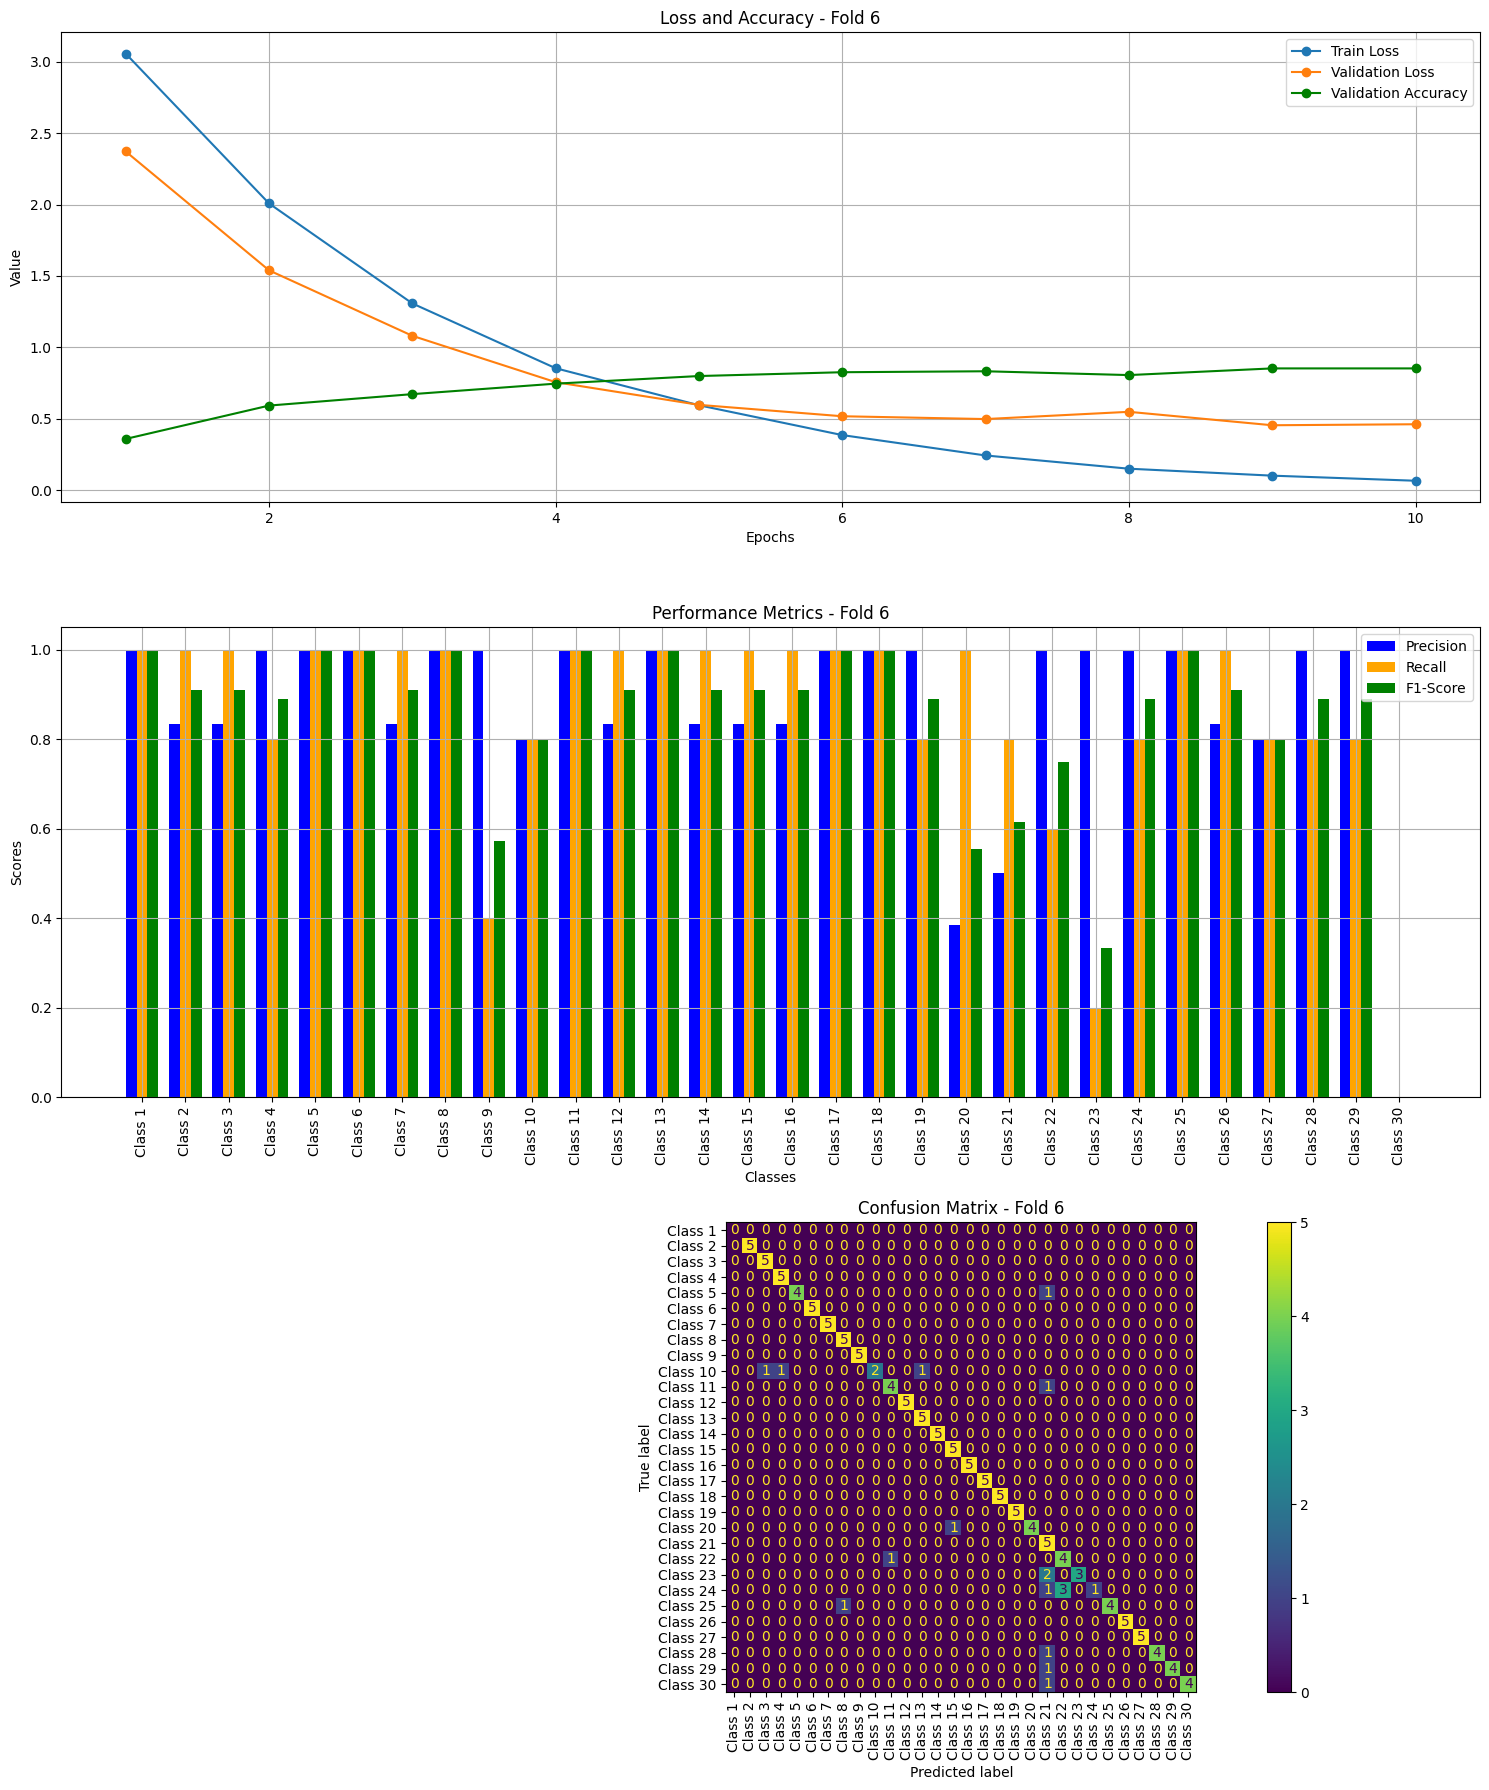

Fold 7/10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.91batch/s]


Validation Loss: 2.3425, Validation Accuracy: 0.3800
Epoch 2/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.85batch/s]


Validation Loss: 1.4356, Validation Accuracy: 0.6533
Epoch 3/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.82batch/s]


Validation Loss: 1.0052, Validation Accuracy: 0.7467
Epoch 4/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.90batch/s]


Validation Loss: 0.8129, Validation Accuracy: 0.7533
Epoch 5/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.85batch/s]


Validation Loss: 0.7248, Validation Accuracy: 0.7667
Epoch 6/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.82batch/s]


Validation Loss: 0.7129, Validation Accuracy: 0.7733
Epoch 7/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.89batch/s]


Validation Loss: 0.7406, Validation Accuracy: 0.7667
Epoch 8/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.90batch/s]


Validation Loss: 0.7146, Validation Accuracy: 0.7467
Epoch 9/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.82batch/s]


Validation Loss: 0.7584, Validation Accuracy: 0.7733
Early stopping triggered.


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.93batch/s]


Metrics for Fold 7 saved to 'performance_metrics_fold_7.csv'.


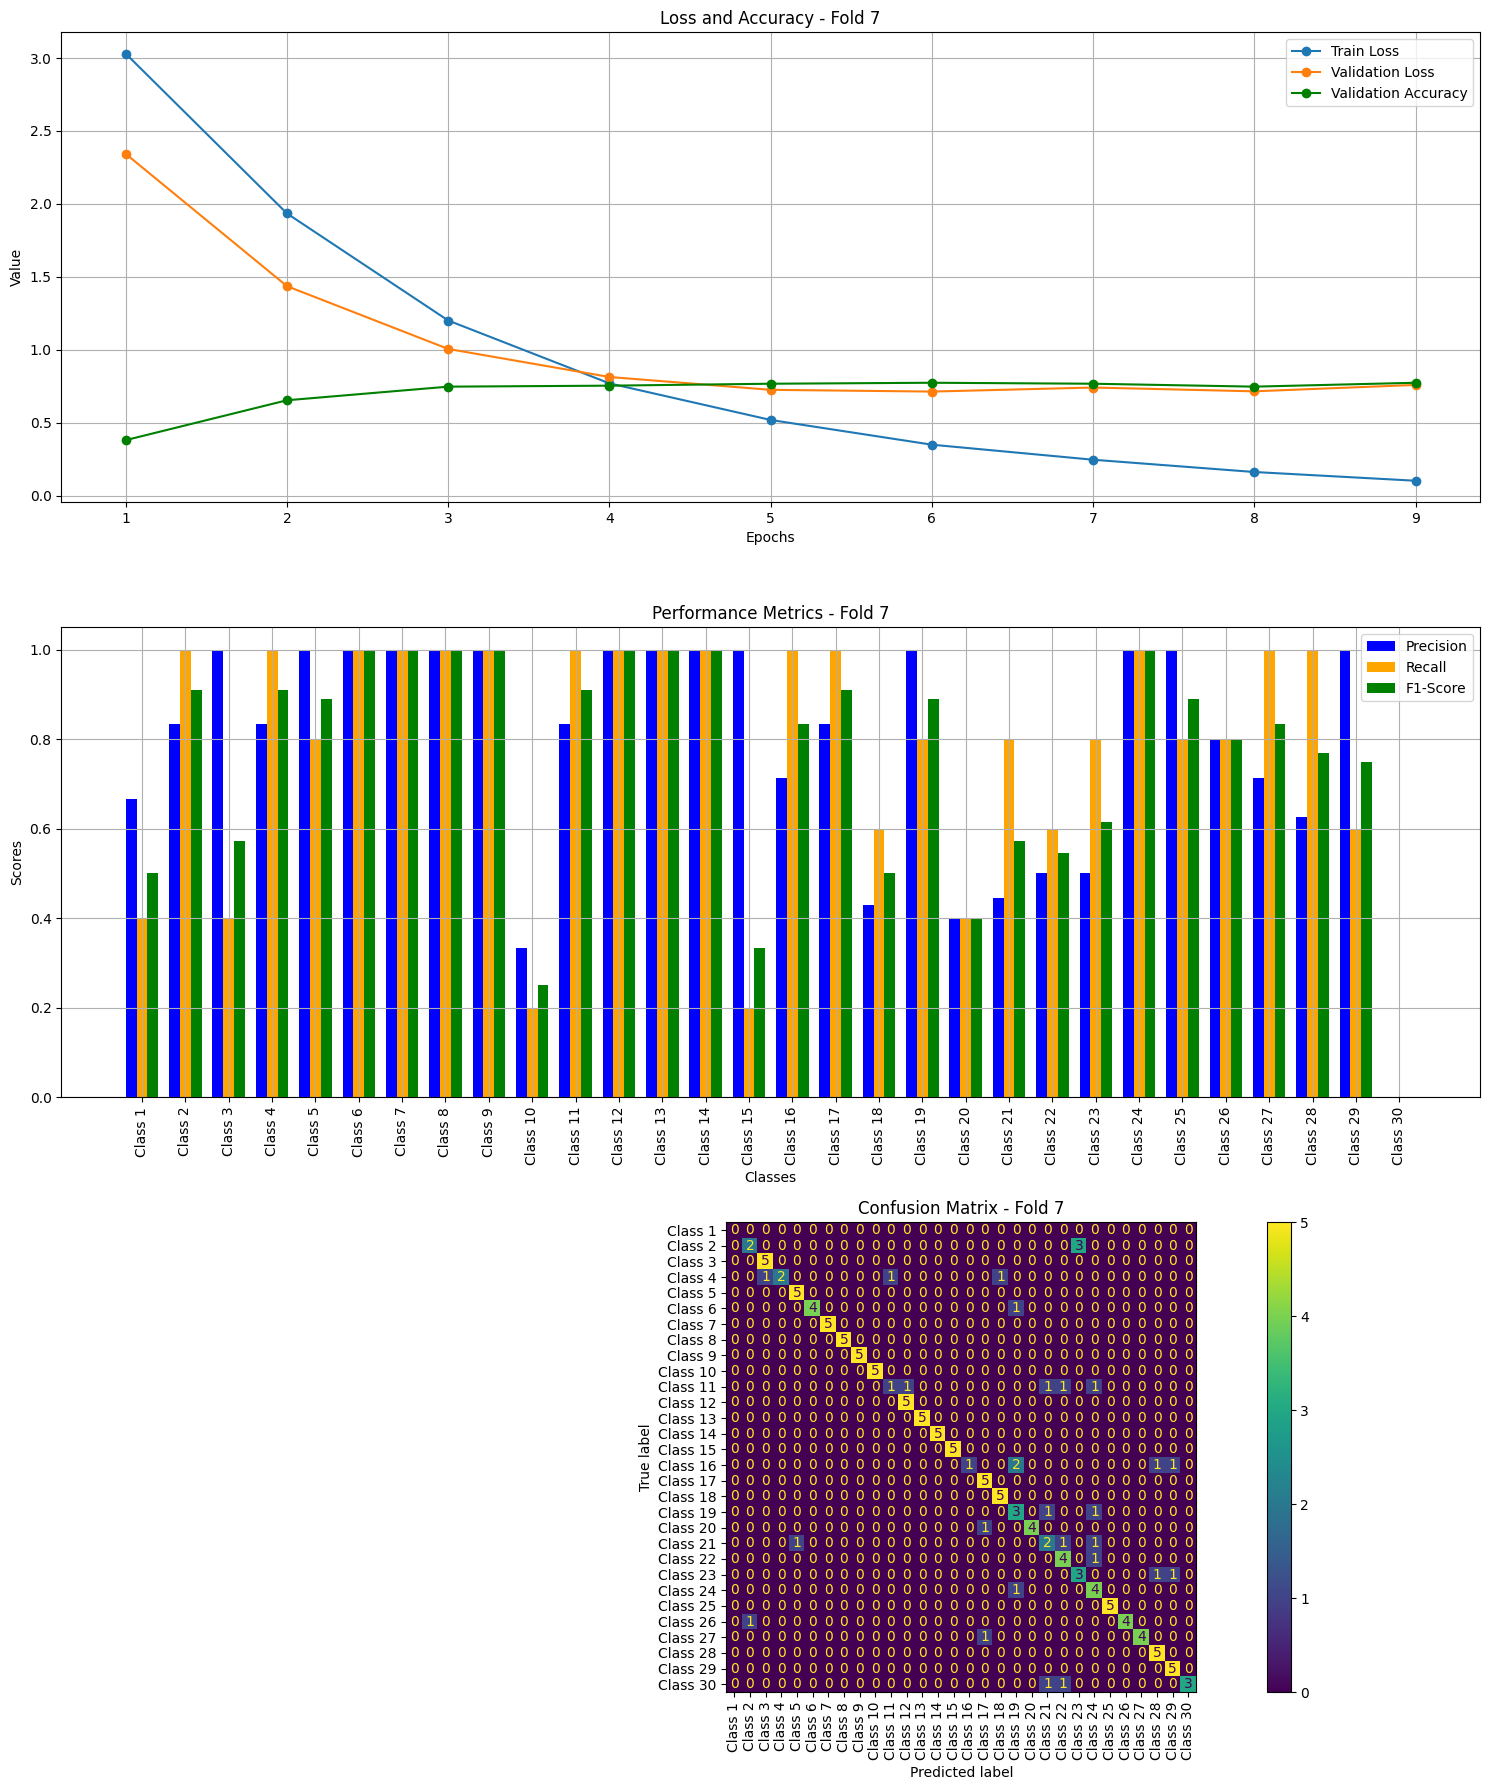

Fold 8/10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.74batch/s]


Validation Loss: 2.6185, Validation Accuracy: 0.2733
Epoch 2/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.90batch/s]


Validation Loss: 1.9369, Validation Accuracy: 0.4600
Epoch 3/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.75batch/s]


Validation Loss: 1.3280, Validation Accuracy: 0.6200
Epoch 4/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.73batch/s]


Validation Loss: 1.0275, Validation Accuracy: 0.6733
Epoch 5/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.63batch/s]


Validation Loss: 0.8451, Validation Accuracy: 0.7200
Epoch 6/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.63batch/s]


Validation Loss: 0.7196, Validation Accuracy: 0.7333
Epoch 7/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.67batch/s]


Validation Loss: 0.7349, Validation Accuracy: 0.7333
Epoch 8/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.75batch/s]


Validation Loss: 0.7039, Validation Accuracy: 0.7667
Epoch 9/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.79batch/s]


Validation Loss: 0.6343, Validation Accuracy: 0.7867
Epoch 10/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.86batch/s]


Validation Loss: 0.5626, Validation Accuracy: 0.8133


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.92batch/s]


Metrics for Fold 8 saved to 'performance_metrics_fold_8.csv'.


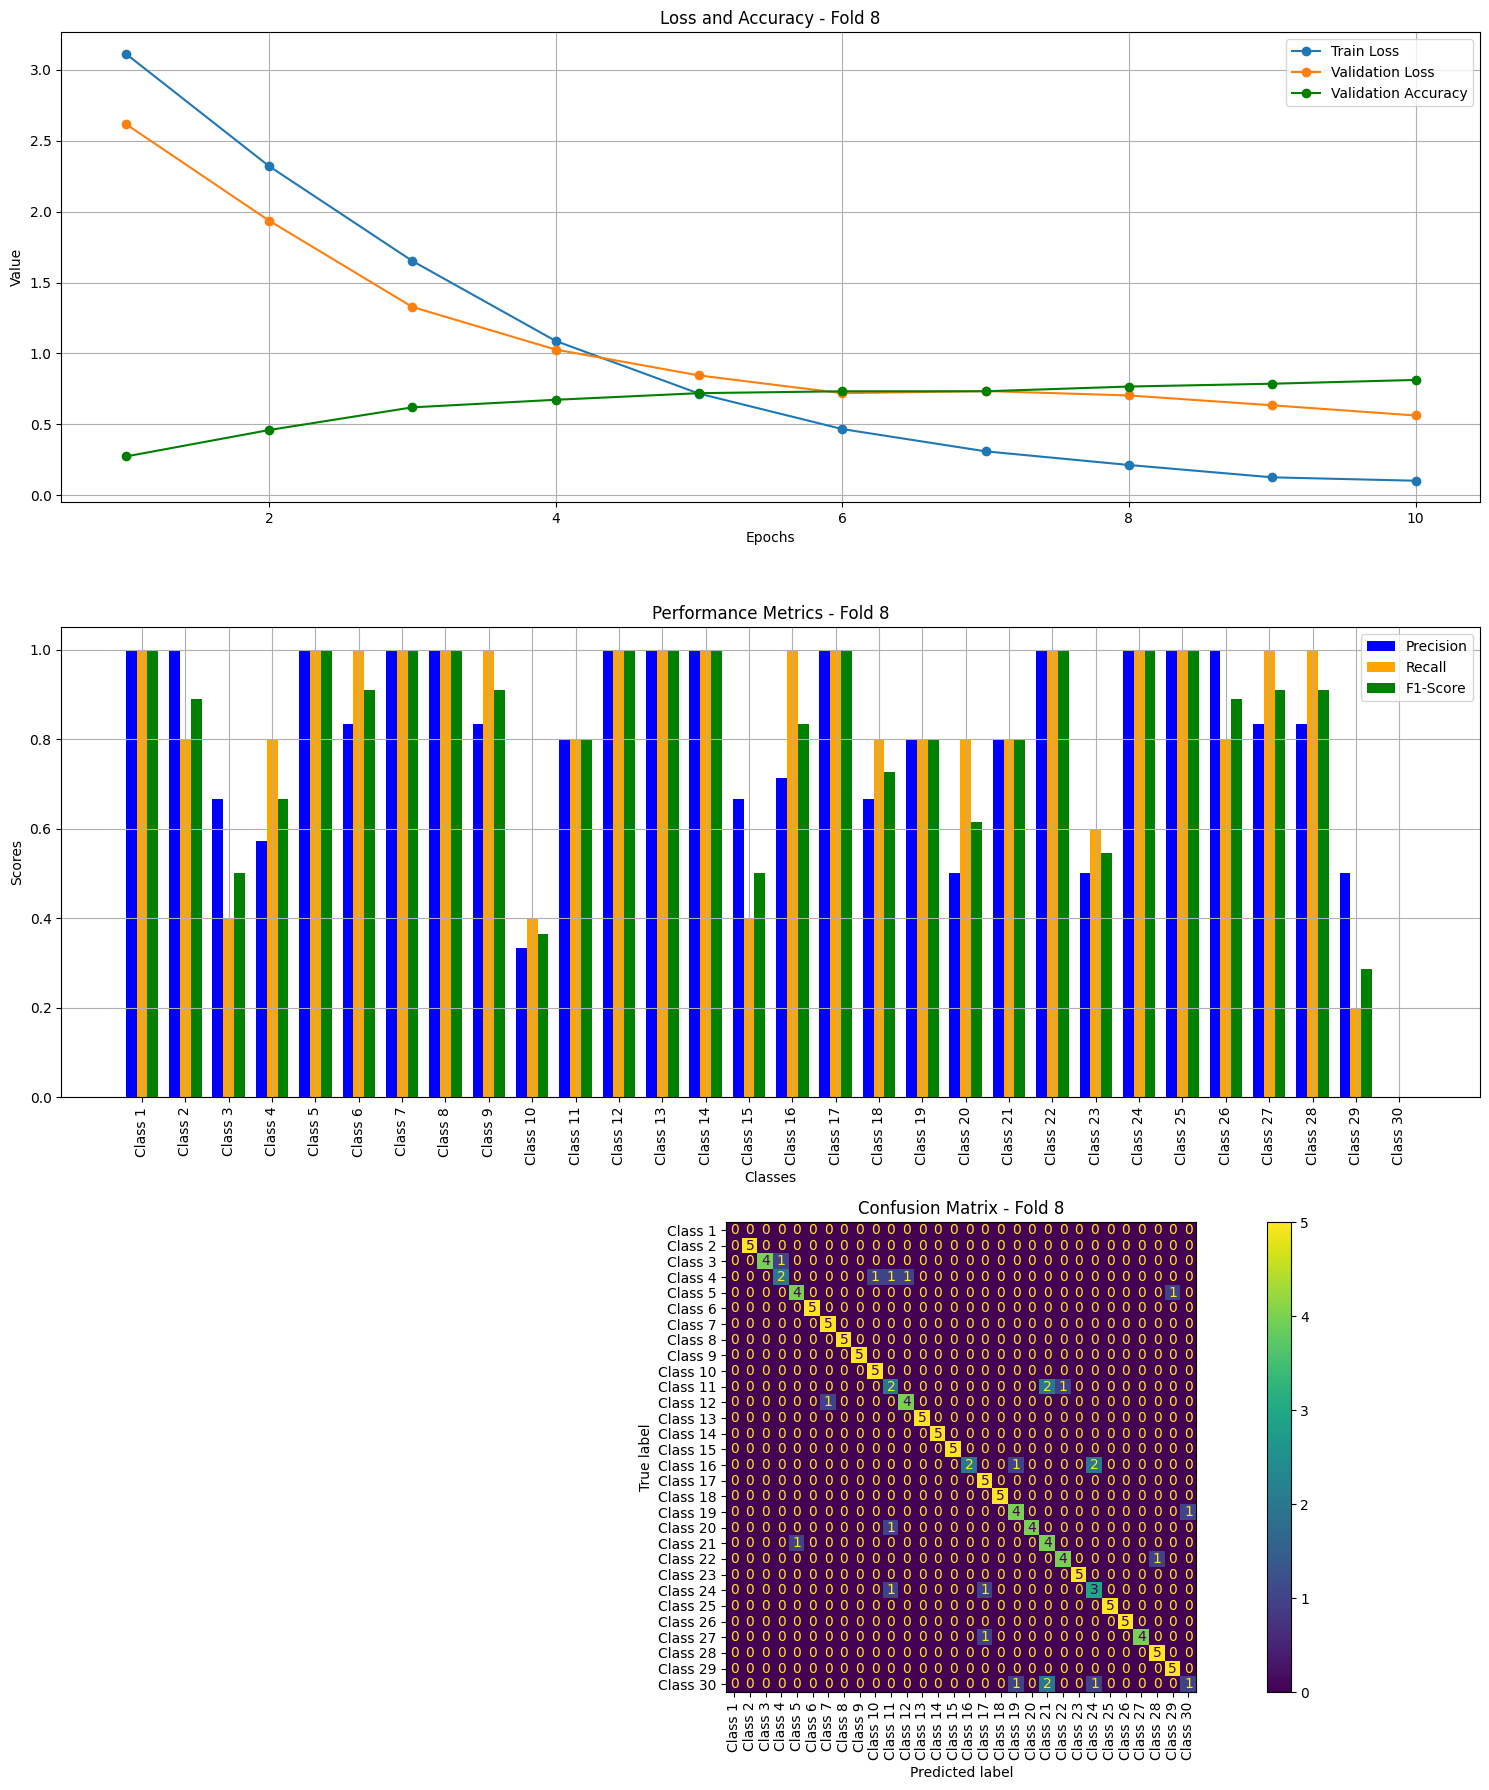

Fold 9/10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.84batch/s]


Validation Loss: 2.3296, Validation Accuracy: 0.3067
Epoch 2/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.80batch/s]


Validation Loss: 1.5310, Validation Accuracy: 0.5333
Epoch 3/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.81batch/s]


Validation Loss: 1.0927, Validation Accuracy: 0.6600
Epoch 4/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.69batch/s]


Validation Loss: 0.7840, Validation Accuracy: 0.7600
Epoch 5/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.83batch/s]


Validation Loss: 0.6383, Validation Accuracy: 0.7600
Epoch 6/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.76batch/s]


Validation Loss: 0.4417, Validation Accuracy: 0.8333
Epoch 7/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.75batch/s]


Validation Loss: 0.4188, Validation Accuracy: 0.8133
Epoch 8/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.83batch/s]


Validation Loss: 0.3331, Validation Accuracy: 0.8400
Epoch 9/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.77batch/s]


Validation Loss: 0.3957, Validation Accuracy: 0.8400
Epoch 10/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.73batch/s]


Validation Loss: 0.4510, Validation Accuracy: 0.8333


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.85batch/s]


Metrics for Fold 9 saved to 'performance_metrics_fold_9.csv'.


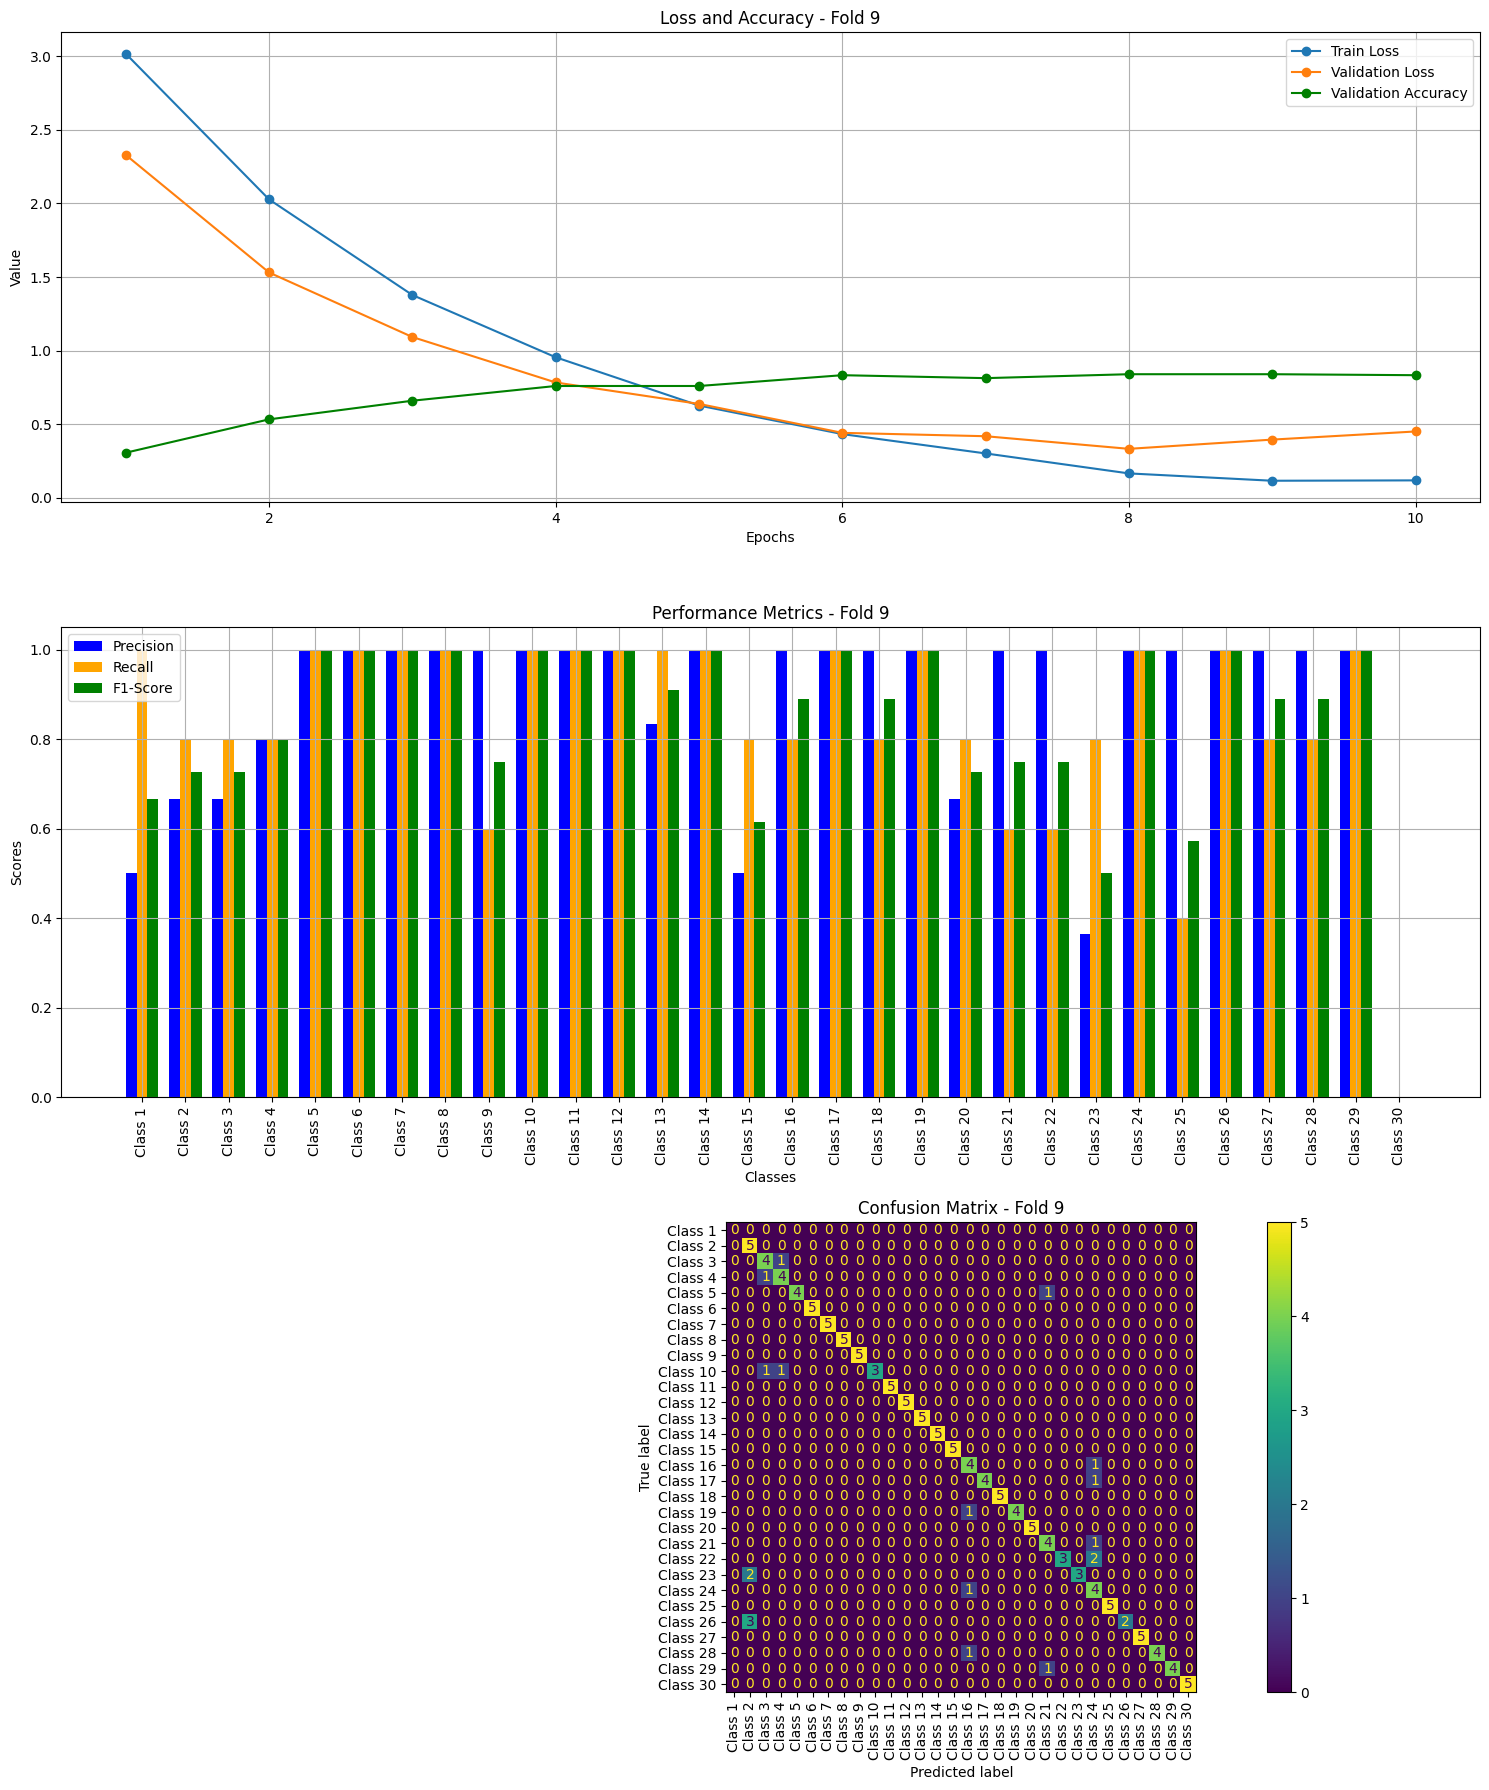

Fold 10/10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.89batch/s]


Validation Loss: 2.3707, Validation Accuracy: 0.3400
Epoch 2/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.83batch/s]


Validation Loss: 1.5525, Validation Accuracy: 0.6067
Epoch 3/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.77batch/s]


Validation Loss: 1.1007, Validation Accuracy: 0.6867
Epoch 4/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.90batch/s]


Validation Loss: 0.8493, Validation Accuracy: 0.7267
Epoch 5/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.72batch/s]


Validation Loss: 0.8599, Validation Accuracy: 0.7133
Epoch 6/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.84batch/s]


Validation Loss: 0.9088, Validation Accuracy: 0.7000
Epoch 7/10


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.76batch/s]


Validation Loss: 0.8773, Validation Accuracy: 0.7200
Early stopping triggered.


Evaluating: 100%|██████████| 19/19 [00:03<00:00,  5.81batch/s]


Metrics for Fold 10 saved to 'performance_metrics_fold_10.csv'.


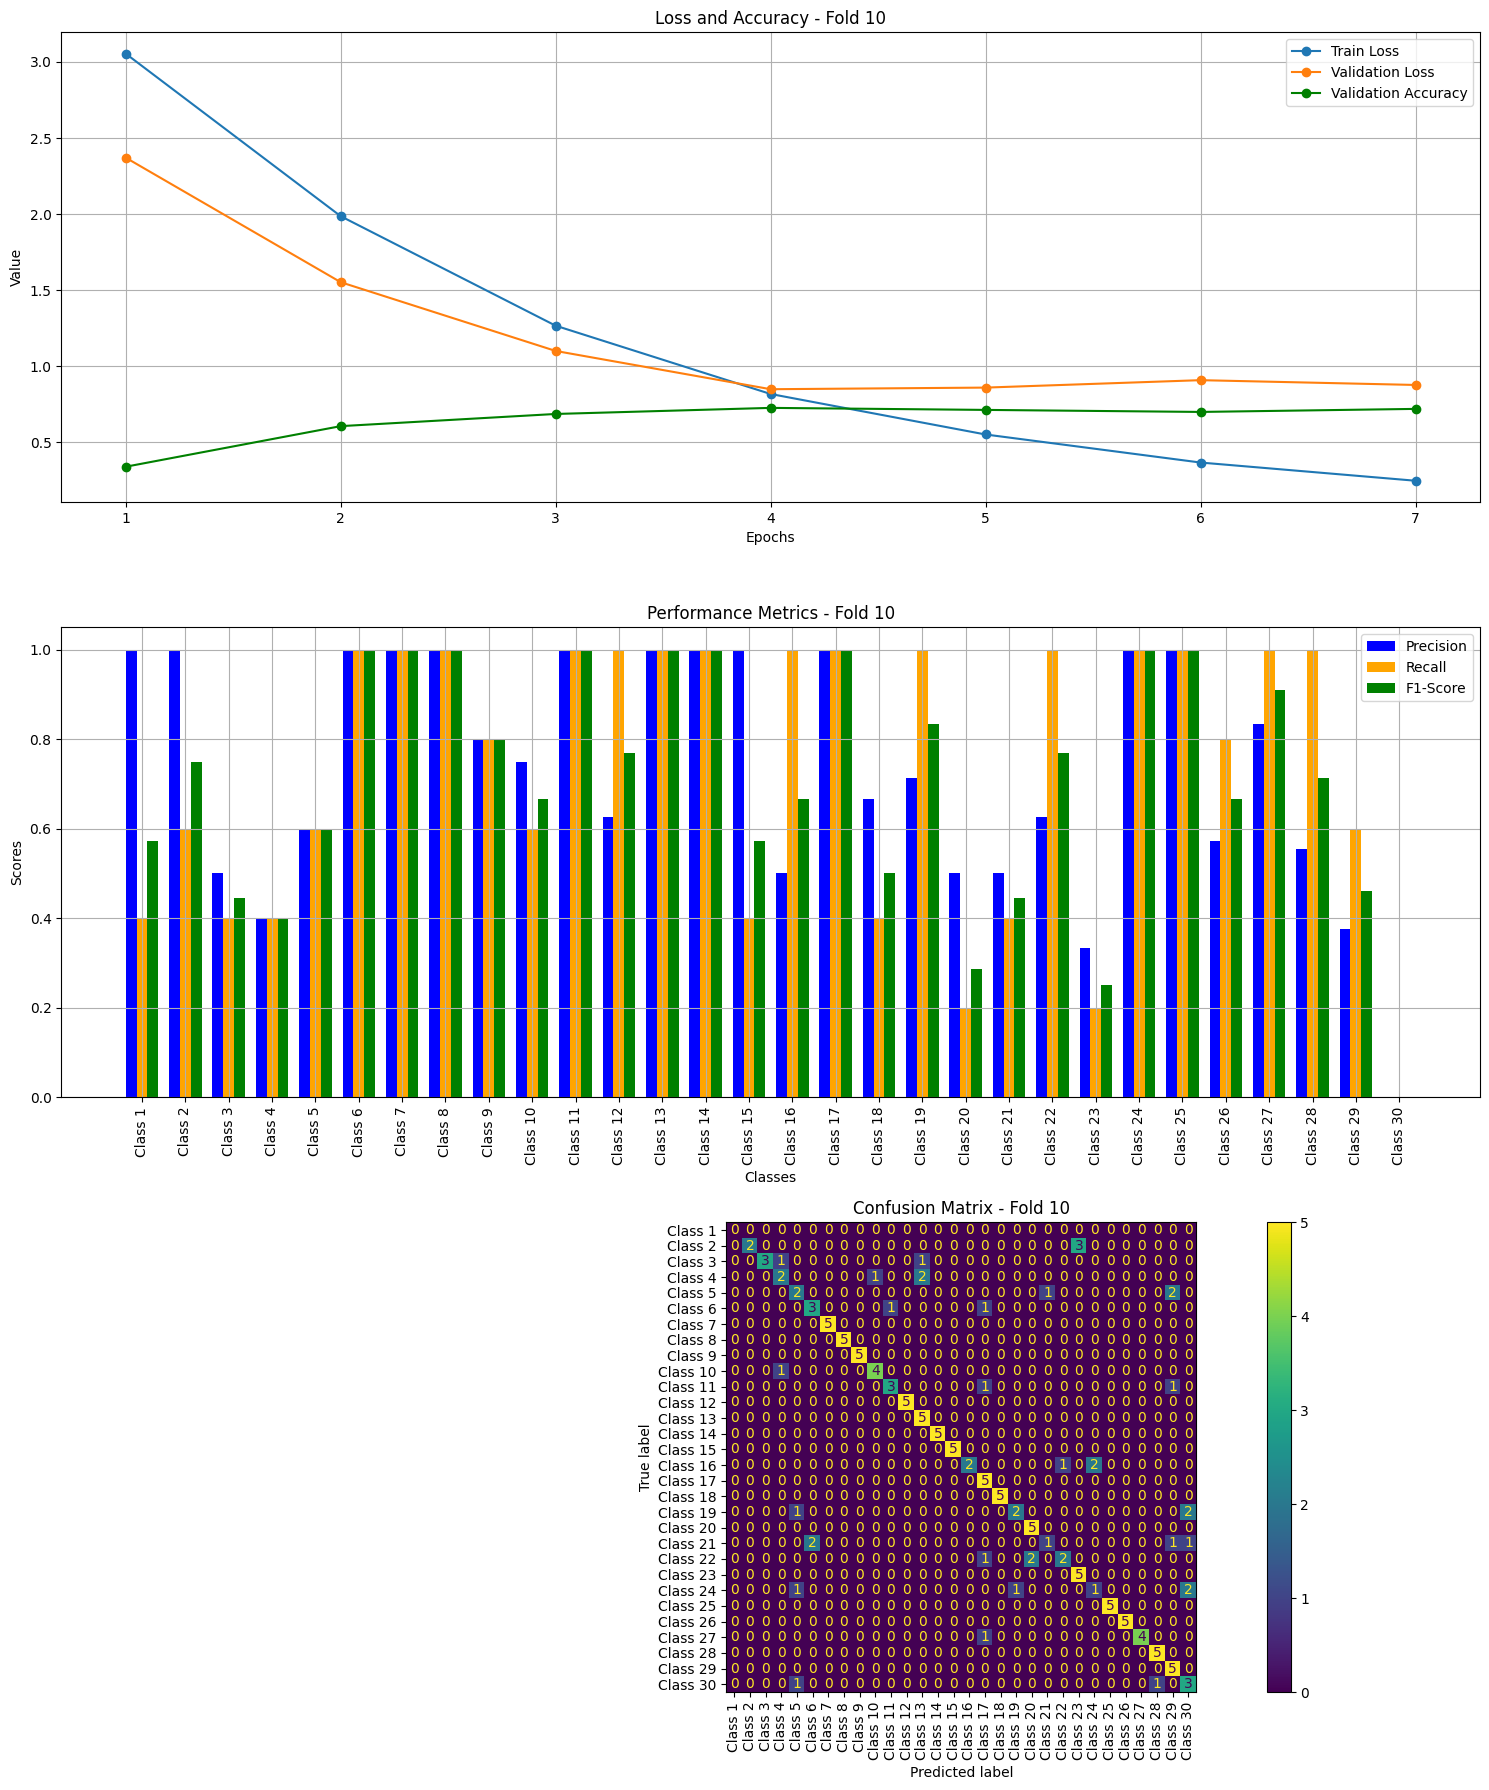

Overall results saved to 'overall_results.csv'.


In [8]:
# --- Execute Cross-Validation ---
fold_results = cross_validate_with_combined_plots(config["model_name"], tokenizer, texts, labels, config)

# --- Save Overall Results ---
results_df = pd.DataFrame(fold_results)
results_df.to_csv("overall_results.csv", index=False)
print("Overall results saved to 'overall_results.csv'.")

In [17]:
def generate_overall_results(fold_metrics_dir, output_filename="overall_performance_metrics.csv"):
    """
    Aggregate fold-level performance metrics into overall results and sort by class.
    
    Args:
        fold_metrics_dir (str): Directory containing fold-level performance CSV files.
        output_filename (str): File to save the aggregated overall results.
    """
    # Gather all fold-level CSV files
    fold_files = glob.glob(os.path.join(fold_metrics_dir, "performance_metrics_fold_*.csv"))
    if not fold_files:
        raise FileNotFoundError("No fold-level performance metrics files found in the directory.")

    # Initialize DataFrame for aggregation
    all_folds_metrics = []

    # Process each fold file
    for file in fold_files:
        fold_df = pd.read_csv(file)
        all_folds_metrics.append(fold_df)

    # Combine all fold data
    combined_df = pd.concat(all_folds_metrics)

    # Exclude the "Average" row for class-level aggregation
    class_only_df = combined_df[~combined_df["Class"].str.contains("Average")]

    # Aggregate metrics by class
    aggregated_metrics = class_only_df.groupby("Class").mean().reset_index()

    # Sort the metrics by Class
    aggregated_metrics["Class"] = aggregated_metrics["Class"].str.extract(r'(\d+)').astype(int)
    aggregated_metrics = aggregated_metrics.sort_values(by="Class").reset_index(drop=True)

    # Compute overall averages
    overall_precision = aggregated_metrics["Precision"].mean()
    overall_recall = aggregated_metrics["Recall"].mean()
    overall_f1 = aggregated_metrics["F1-Score"].mean()

    # Add "Average" row to the results using pd.concat
    average_row = pd.DataFrame(
        {
            "Class": ["Average"],
            "Precision": [overall_precision],
            "Recall": [overall_recall],
            "F1-Score": [overall_f1],
        }
    )
    aggregated_metrics = pd.concat([aggregated_metrics, average_row], ignore_index=True)

    # Save to a new CSV file
    aggregated_metrics.to_csv(output_filename, index=False)
    print(f"Overall performance metrics saved to '{output_filename}'.")

    # Display the final table
    #print(aggregated_metrics)

    return aggregated_metrics


In [20]:

def display_as_dataframe(aggregated_metrics):
    """
    Display the overall performance metrics as a clean DataFrame.

    Args:
        aggregated_metrics (pd.DataFrame): DataFrame containing overall performance metrics.
    """
    # Rename columns to match the teacher's format
    aggregated_metrics = aggregated_metrics.rename(columns={"Class": " ", "Precision": "Precision", "Recall": "Recall", "F1-Score": "F-Score"})
    
    # Display the DataFrame as is
    display(aggregated_metrics.style.set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
         {'selector': 'td', 'props': [('text-align', 'center')]}]
    ).set_caption("Overall Performance Metrics"))
    

# Directory containing fold-level metrics
fold_metrics_dir = "fold_metrics"

overall_results = generate_overall_results(fold_metrics_dir, output_filename="overall_performance_metrics.csv")
# Call the function to display
display_as_dataframe(overall_results)


Overall performance metrics saved to 'overall_performance_metrics.csv'.


,,Precision,Recall,F-Score
0,1,0.801429,0.820000,0.782597
1,2,0.835556,0.880000,0.840570
2,3,0.841667,0.620000,0.695779
3,4,0.749048,0.820000,0.776465
4,5,0.856667,0.840000,0.842525
5,6,0.966667,1.000000,0.981818
6,7,0.983333,1.000000,0.990909
7,8,1.000000,1.000000,1.000000
8,9,0.849643,0.740000,0.760531
9,10,0.668333,0.600000,0.611257
